In [119]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import os

# resnet50
from keras.applications import MobileNetV2

# Prétraitement des données

In [127]:
train_dir ='datafood/Fast Food Classification V2/Train'
valid_dir = 'datafood/Fast Food Classification V2/Valid'


from pathlib import Path
import imghdr
# outputs_folder = 'test2/'
# img_format = ('JPEG','PNG','GIF','BMP')

# for filename in os.listdir(valid_dir): 
#     if not filename.endswith(img_format):
#         continue

#     img = Image.open(train_dir + filename)

#     img = img.convert('RGB')

#     img.save(outputs_folder + filename.split('.')[0] + "jpeg")

# data_dir = 'datafood/Fast Food Classification V2/Train'
# image_extensions = [".png", ".jpg"]

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_dir).rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [133]:
# Augment train set only
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

train_data_generator = ImageDataGenerator(
                    validation_split=0.15,
                    rotation_range=15,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function=preprocess_input,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

val_data_generator = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    validation_split=0.15)

In [134]:
HYP = dict(
    seed = 77,
    batch_size = 32,
    img_size = (160, 160),
    epochs = 20,
    patience = 5)

In [135]:
train_generator = train_data_generator.flow_from_directory(
                train_dir, target_size=HYP['img_size'],
                shuffle=True, seed=HYP['seed'],
                class_mode='categorical', 
                batch_size=HYP['batch_size'],
                subset="training")

validation_generator = val_data_generator.flow_from_directory(
                    train_dir, target_size=HYP['img_size'],
                    shuffle=False, seed=HYP['seed'],
                    class_mode='categorical',
                    batch_size=HYP['batch_size'],
                    subset="validation")

Found 12745 images belonging to 10 classes.
Found 2248 images belonging to 10 classes.


# Learning Rate schedule

In [136]:
# LearningRateScheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.001 * (5 - epoch))
    
lr_scheduler = LearningRateScheduler(scheduler)

# early_stopping    
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)

callbacks = [early_stopping, lr_scheduler]

# Modeling

In [137]:
# MobileNetV2
model_mobileNetV2 = Sequential()

model_mobileNetV2.add(MobileNetV2(
include_top=False,
pooling='avg',
weights='imagenet'
))

model_mobileNetV2.add(Dense(1024, activation='relu'))

model_mobileNetV2.add(Dropout(0.5))

model_mobileNetV2.add(Dense(10, activation='softmax'))

model_mobileNetV2.layers[0].trainable = False

model_mobileNetV2.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

model_mobileNetV2.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3,579,978
Trainable params: 1,321,994
Non-trainable params: 2,257,984
_________________________________________________________________


# Learning

In [138]:
fit_history = model_mobileNetV2.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch_training,
            validation_steps=steps_per_epoch_validation,
            epochs=HYP['epochs'],
            validation_data=validation_generator,
            verbose=1,
            callbacks=callbacks
            )

Epoch 1/20
260/399 [==================>...........] - ETA: 47s - loss: 1.1987 - accuracy: 0.6303

c:\Users\devia.e13\Anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


399/399 [==============================] - 161s 398ms/step - loss: 1.1141 - accuracy: 0.6519 - val_loss: 0.7367 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 2/20
399/399 [==============================] - 159s 399ms/step - loss: 0.8535 - accuracy: 0.7215 - val_loss: 0.7167 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 3/20
399/399 [==============================] - 165s 414ms/step - loss: 0.7970 - accuracy: 0.7428 - val_loss: 0.6755 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 4/20
399/399 [==============================] - 154s 386ms/step - loss: 0.7537 - accuracy: 0.7535 - val_loss: 0.6790 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 5/20
399/399 [==============================] - 154s 385ms/step - loss: 0.7253 - accuracy: 0.7651 - val_loss: 0.6634 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 6/20
399/399 [==============================] - 147s 368ms/step - loss: 0.6957 - accuracy: 0.7703 - val_loss: 0.6551 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 7/20
399/399 [==============================] - 141

## Evalutation du model

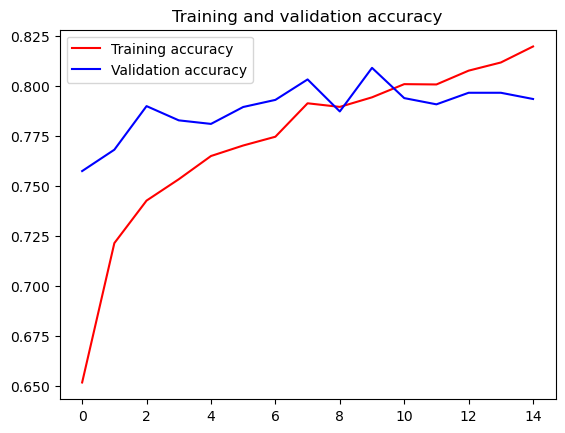

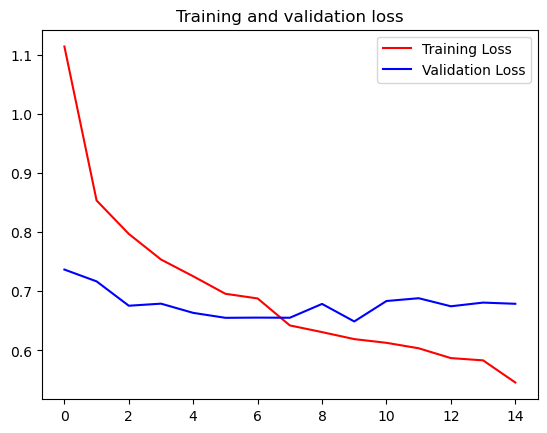

In [139]:
acc = fit_history.history['accuracy']
val_acc = fit_history.history['val_accuracy']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

In [140]:
score = model_mobileNetV2.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6787980794906616
Test accuracy: 0.7935943007469177


71/71 [==============================] - 19s 261ms/step


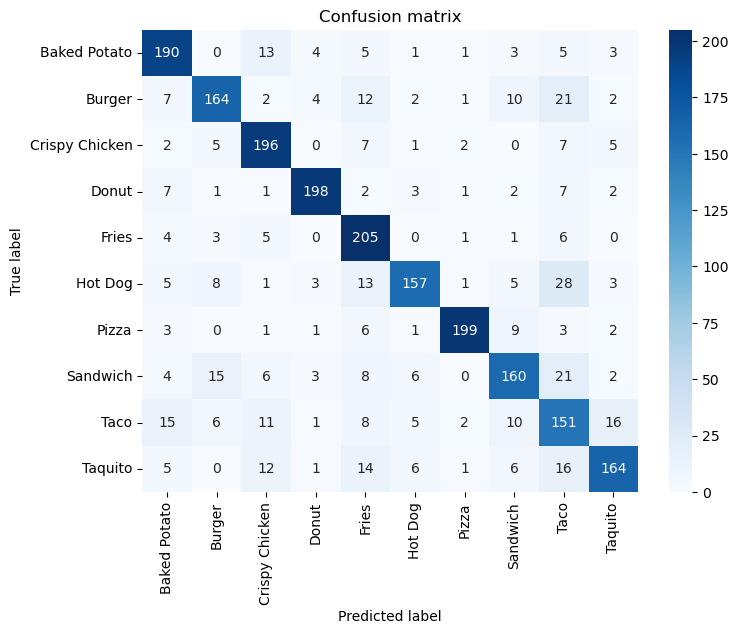

In [141]:
# Confusion matrix

classes = train_generator.class_indices.keys()

y_pred = np.argmax(model_mobileNetV2.predict(validation_generator), axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Save

In [142]:
from tensorflow.keras.models import load_model

In [143]:
model_mobileNetV2.save(os.path.join('models','MobileNet_10Classes.h5'))
new_model = load_model('models/MobileNet_10Classes.h5')